**PROYECTO INTEGRADOR FAKE NEWS**

Como la extensa difusión de noticias falsas puede tener un impacto negativo grave en los individuos y en la sociedad, la falta de estrategias de verificación de hechos escalables es especialmente preocupante. 

El problema como bien se introdujo anteriormente son la cantidad de noticias falsas que abundan en estos tiempos. Estamos interesados en crear una IA con Machine Learning , por medio de un Dataset escogido para el entrenamiento de dicha Inteligencia Artificial, para que en un futuro pueda funcionar propiamente recopilando información de todos los sitios web y así verificar la veracidad de las noticias  

Importaciones de librerias para python

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [ ]:
# Cargamos nuestro drive en el notebook de trabajo
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#copiamos el archivo csv de mis archivos drive
!cp "/content/drive/My Drive/ProyectoFinal/DataSet/Fake.csv" Fake.csv

In [ ]:
#copiamos el archivo csv de mis archivos drive
!cp "/content/drive/My Drive/ProyectoFinal/DataSet/True.csv" True.csv

Importaciones de librerias y dependencias

In [ ]:
!pip install -q py4j
!pip install pyspark

     |████████████████████████████████| 200 kB 12.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 36 kB/s 
     |████████████████████████████████| 199 kB 62.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=54ccbc1c61e36f24ce6b6ed1850b5d8f624dfac8d4686d9a827e38a5c4bafed9
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.sql.types import StringType, StructType, StructField, IntegerType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.sql import functions as F

Leer los datasets

In [ ]:
fake = pd.read_csv("Fake.csv")
true = pd.read_csv("True.csv")

In [ ]:
fake.shape

(23481, 4)

In [ ]:
true.shape

(21417, 4)

Preparacion y limpieza de datos

In [ ]:
#etiquetar las noticias
fake['target'] = 'fake'
true['target'] = 'true'

In [ ]:
fake.head()

,title,text,subject,date,target
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",fake


In [ ]:
true.head()

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",true
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",true
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",true
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",true
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",true


In [ ]:
spark = SparkSession.builder.master('local[*]').getOrCreate()

In [ ]:
schema = StructType([
    StructField('title', StringType(), True),
    StructField('text', StringType(), True),
    StructField('subject', StringType(), True),
    StructField('date', StringType(), True),
    StructField('target', StringType(), True)
])

In [ ]:
df_true = spark.read.schema(schema).options(header=True).option("sep", ",").option("inferSchema", "true").csv("True.csv")
df_true.toPandas().head(20)
df_true.show()

+--------------------+--------------------+--------------------+------------------+------------------+
|               title|                text|             subject|              date|            target|
+--------------------+--------------------+--------------------+------------------+------------------+
|As U.S. budget fi...|WASHINGTON (Reute...|        politicsNews|December 31, 2017 |              null|
|U.S. military to ...|WASHINGTON (Reute...|        politicsNews|December 29, 2017 |              null|
|Senior U.S. Repub...|WASHINGTON (Reute...|        politicsNews|December 31, 2017 |              null|
|FBI Russia probe ...|WASHINGTON (Reute...|        politicsNews|December 30, 2017 |              null|
|Trump wants Posta...|SEATTLE/WASHINGTO...|        politicsNews|December 29, 2017 |              null|
|White House, Cong...|WEST PALM BEACH, ...|        politicsNews|December 29, 2017 |              null|
|Trump says Russia...|WEST PALM BEACH, ...|        politicsNews|December 

In [ ]:
df_new_true = df_true.fillna(value="true")
df_new_true.show()

+--------------------+--------------------+--------------------+------------------+------------------+
|               title|                text|             subject|              date|            target|
+--------------------+--------------------+--------------------+------------------+------------------+
|As U.S. budget fi...|WASHINGTON (Reute...|        politicsNews|December 31, 2017 |              true|
|U.S. military to ...|WASHINGTON (Reute...|        politicsNews|December 29, 2017 |              true|
|Senior U.S. Repub...|WASHINGTON (Reute...|        politicsNews|December 31, 2017 |              true|
|FBI Russia probe ...|WASHINGTON (Reute...|        politicsNews|December 30, 2017 |              true|
|Trump wants Posta...|SEATTLE/WASHINGTO...|        politicsNews|December 29, 2017 |              true|
|White House, Cong...|WEST PALM BEACH, ...|        politicsNews|December 29, 2017 |              true|
|Trump says Russia...|WEST PALM BEACH, ...|        politicsNews|December 

In [ ]:
df_fake = spark.read.schema(schema).options(header=True).option("sep", ",").option("inferSchema", "true").csv("Fake.csv")
df_fake.toPandas().head(20)
df_fake.show()

+--------------------+--------------------+-------+-----------------+------+
|               title|                text|subject|             date|target|
+--------------------+--------------------+-------+-----------------+------+
| Donald Trump Sen...|Donald Trump just...|   News|December 31, 2017|  null|
| Drunk Bragging T...|House Intelligenc...|   News|December 31, 2017|  null|
| Sheriff David Cl...|On Friday, it was...|   News|December 30, 2017|  null|
| Trump Is So Obse...|On Christmas day,...|   News|December 29, 2017|  null|
| Pope Francis Jus...|Pope Francis used...|   News|December 25, 2017|  null|
| Racist Alabama C...|The number of cas...|   News|December 25, 2017|  null|
| Fresh Off The Go...|Donald Trump spen...|   News|December 23, 2017|  null|
| Trump Said Some ...|In the wake of ye...|   News|December 23, 2017|  null|
| Former CIA Direc...|Many people have ...|   News|December 22, 2017|  null|
| WATCH: Brand-New...|Just when you mig...|   News|December 21, 2017|  null|

In [ ]:
df_new_fake = df_fake.fillna(value="fake")
df_new_fake.show()

+--------------------+--------------------+-------+-----------------+------+
|               title|                text|subject|             date|target|
+--------------------+--------------------+-------+-----------------+------+
| Donald Trump Sen...|Donald Trump just...|   News|December 31, 2017|  fake|
| Drunk Bragging T...|House Intelligenc...|   News|December 31, 2017|  fake|
| Sheriff David Cl...|On Friday, it was...|   News|December 30, 2017|  fake|
| Trump Is So Obse...|On Christmas day,...|   News|December 29, 2017|  fake|
| Pope Francis Jus...|Pope Francis used...|   News|December 25, 2017|  fake|
| Racist Alabama C...|The number of cas...|   News|December 25, 2017|  fake|
| Fresh Off The Go...|Donald Trump spen...|   News|December 23, 2017|  fake|
| Trump Said Some ...|In the wake of ye...|   News|December 23, 2017|  fake|
| Former CIA Direc...|Many people have ...|   News|December 22, 2017|  fake|
| WATCH: Brand-New...|Just when you mig...|   News|December 21, 2017|  fake|

In [ ]:
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [ ]:
data.head(5)

,title,text,subject,date,target
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",fake


In [ ]:
data.tail(5)

,title,text,subject,date,target
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",true
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",true
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",true
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",true
44897,Indonesia to buy $1.14 billion worth of Russia...,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,worldnews,"August 22, 2017",true


In [ ]:
#ordenacion y shuffling de los datos
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [ ]:
data.head()

,title,text,subject,date,target
0,HOW HILLARY DESTROYED This Man’s Life To Hide ...,Does anyone even care that this American man w...,left-news,"Sep 14, 2016",fake
1,Incompetent Trump WH Already F**king Up; Has ...,Donald Trump is easily the most unprepared and...,News,"January 29, 2017",fake
2,Nigeria set to start mass trial of Boko Haram ...,"ABUJA (Reuters) - The trial of more than 1,600...",worldnews,"October 9, 2017",true
3,Myriad of ways the CIA tried (and failed) to a...,RTThe father of the Cuban Revolution remains u...,Middle-east,"November 27, 2016",fake
4,Two White House officials helped give Nunes in...,WASHINGTON (Reuters) - Two White House officia...,politicsNews,"March 30, 2017",true


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   target   44898 non-null  object
dtypes: object(5)
memory usage: 1.7+ MB


In [ ]:
#remover las fechas de los textos
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,HOW HILLARY DESTROYED This Man’s Life To Hide ...,Does anyone even care that this American man w...,left-news,fake
1,Incompetent Trump WH Already F**king Up; Has ...,Donald Trump is easily the most unprepared and...,News,fake
2,Nigeria set to start mass trial of Boko Haram ...,"ABUJA (Reuters) - The trial of more than 1,600...",worldnews,true
3,Myriad of ways the CIA tried (and failed) to a...,RTThe father of the Cuban Revolution remains u...,Middle-east,fake
4,Two White House officials helped give Nunes in...,WASHINGTON (Reuters) - Two White House officia...,politicsNews,true


In [ ]:
#remover el titulo
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,Does anyone even care that this American man w...,left-news,fake
1,Donald Trump is easily the most unprepared and...,News,fake
2,"ABUJA (Reuters) - The trial of more than 1,600...",worldnews,true
3,RTThe father of the Cuban Revolution remains u...,Middle-east,fake
4,WASHINGTON (Reuters) - Two White House officia...,politicsNews,true


In [ ]:
#convertir los texto en minusculas
data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,does anyone even care that this american man w...,left-news,fake
1,donald trump is easily the most unprepared and...,News,fake
2,"abuja (reuters) - the trial of more than 1,600...",worldnews,true
3,rtthe father of the cuban revolution remains u...,Middle-east,fake
4,washington (reuters) - two white house officia...,politicsNews,true


In [ ]:
#remover puntuacion de los textos
import string

#funcion para quitar la puntuacion
def remover_puntuacion(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(remover_puntuacion)

In [ ]:
#verificar
data.head()

,text,subject,target
0,does anyone even care that this american man w...,left-news,fake
1,donald trump is easily the most unprepared and...,News,fake
2,abuja reuters the trial of more than 1600 peo...,worldnews,true
3,rtthe father of the cuban revolution remains u...,Middle-east,fake
4,washington reuters two white house officials ...,politicsNews,true


In [ ]:
# eliminar palabras vacias del dataset
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#verificar
data.head()

,text,subject,target
0,anyone even care american man picked thin air ...,left-news,fake
1,donald trump easily unprepared incompetent per...,News,fake
2,abuja reuters trial 1600 people suspected ties...,worldnews,true
3,rtthe father cuban revolution remains unbeaten...,Middle-east,fake
4,washington reuters two white house officials p...,politicsNews,true


subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


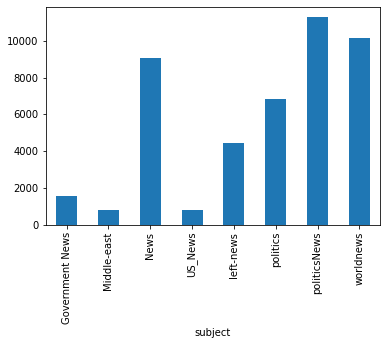

In [ ]:
#cantidad de articulos por tema
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


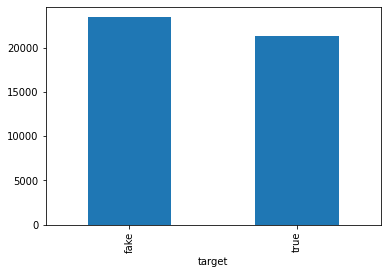

In [ ]:
#cantidad de articulos reales y falsos
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

In [ ]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


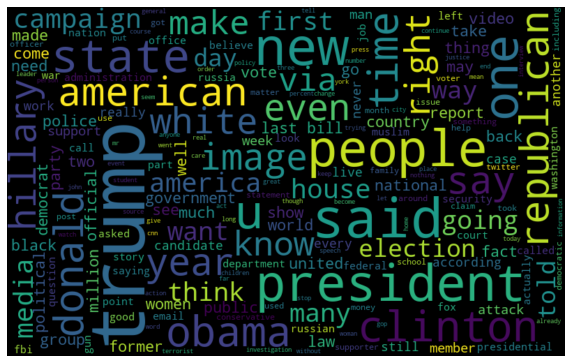

In [ ]:
#usamos wordcloud para saber que palabras son usadas en las noticias falsas
from wordcloud import WordCloud

fake_data = data[data["target"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

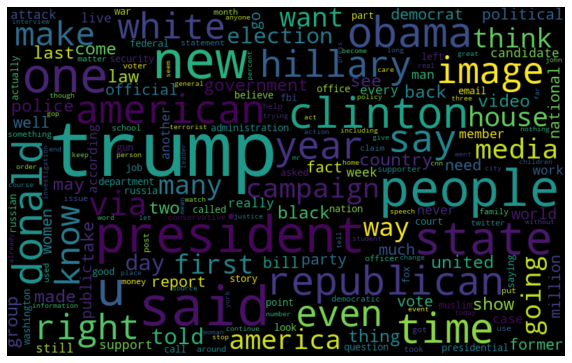

In [ ]:
#usamos wordcloud para saber que palabras son usadas en las noticias reales
from wordcloud import WordCloud

real_data = data[data["target"] == "true"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
#que palabras son mas usadas hallamos la cantidad   
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

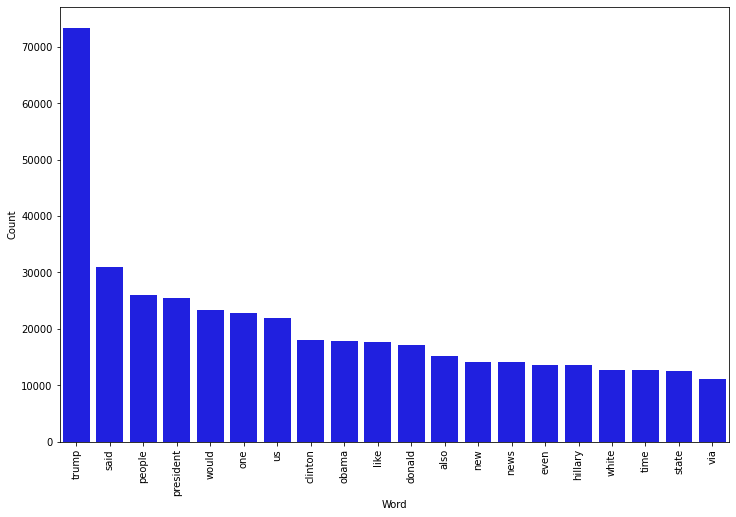

In [ ]:
#cantidad de palabras mas usadas en las noticias falsas
counter(data[data["target"] == "fake"], "text", 20)

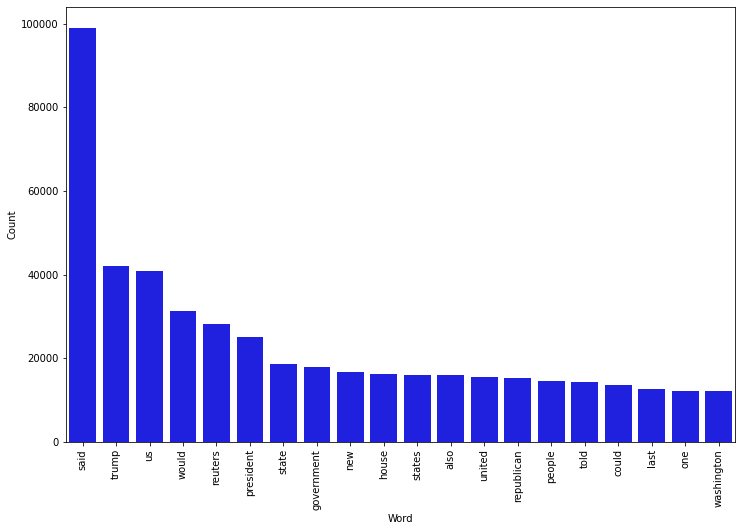

In [ ]:
#cantidad de palabras mas usadas en las noticias reales
counter(data[data["target"] == "true"], "text", 20)

In [ ]:
#funcion para hallar la matriz confusion
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

In [ ]:
X_train.head()

36335    daily shooter 21st century wirelast night high...
12384    republicans delusional really believe forgoing...
24419    finally watching end times hollywood celebriti...
24740    new york reuters democratic party activists us...
27039    every american concerned demanding answers was...
Name: text, dtype: object

In [ ]:
y_train.head()

36335    fake
12384    fake
24419    fake
24740    true
27039    fake
Name: target, dtype: object

In [ ]:
from sklearn.tree import DecisionTreeClassifier

#vectorizacion y aplicacion en el modelo
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
#entrenamiento del modelo
model = pipe.fit(X_train, y_train)

#precision para la prediccion
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.67%


Confusion matrix, without normalization


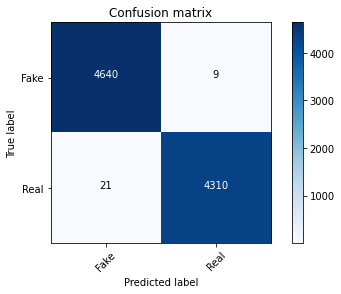

In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])